<a href="https://colab.research.google.com/github/kb22/Tensorflow-Course/blob/master/Transfer_learning_on_Cats_n_Dogs_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning on Cats and Dogs Dataset

While it's always exciting to develop a deep neural network from scratch, sometimes there are models already trainined on many many images which we can reuse for our own use case. Transfer learning is a technique that takes a pre-trained model to make predictions on a completely different dataset.

In this notebook, I'll use the MobileNet model to train and predict on the cats and dogs dataset.

## Load essential libraries

The first step is to install tensorflow hub and datasets and then import them.

In [1]:
!pip install tf-nightly-gpu
!pip install "tensorflow-hub"
!pip install -U tensorflow_datasets

     |████████████████████████████████| 400.2MB 39kB/s 
     |████████████████████████████████| 3.9MB 28.0MB/s 
     |████████████████████████████████| 501kB 38.5MB/s 
     |████████████████████████████████| 61kB 22.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built opt-einsum
     |████████████████████████████████| 686kB 2.8MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

W0719 08:22:45.274919 139871101114240 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.enable_eager_execution is deprecated. Please use tf.compat.v1.enable_eager_execution instead.



The command `tf.enable_eager_execution()` ensures that all commands in tensorflow run as they are executed and not wait till the end and graph creations.

## Import dataset

I'll now import the dataset - Cats and Dogs and split it in the ratio 80:20.

In [3]:
splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = tfds.Split.ALL.subsplit(weighted=(80, 20)))

(train_dataset, validation_dataset) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

W0719 08:23:42.577321 139871101114240 cats_vs_dogs.py:107] 1738 images were corrupted and were skipped


W0719 08:23:42.629613 139871101114240 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:247: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


W0719 08:23:51.370710 139871101114240 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



As the size of each image is different, I'll resize them all to the same size. The MobileNet model expects the image size to be 224x224, so I'll resize the images with that.

In [0]:
IMAGE_RES = 224
BATCH_SIZE = 32

def normalize(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

train_dataset =  train_dataset.repeat().shuffle(buffer_size = num_examples//4).map(normalize).batch(BATCH_SIZE).prefetch(1)
validation_dataset  =  validation_dataset.map(normalize).batch(BATCH_SIZE).prefetch(1)

## Create the model

Using the MobileNet model, I'll now create the model that can train on the cats and dogs dataset and can make correct predictions. I'll also freeze the mobileNet layers as I do not want their weights to change when training on the new dataset.

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
mobileNetModel = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
mobileNetModel.trainable = False

In [6]:
model = Sequential([
    mobileNetModel,
    Dense(units = 2, activation = tf.nn.softmax)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


I'll now compile the model.

In [0]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## Training the model

I'll now train the model that I just created and check its accuracy.

In [8]:
EPOCHS = 5

history = model.fit(train_dataset, steps_per_epoch = int(np.ceil((0.8*num_examples)/BATCH_SIZE)), epochs = EPOCHS, validation_data = validation_dataset, verbose = 1)

Epoch 1/5


W0719 08:24:05.409240 139871101114240 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1251: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0719 08:24:05.542983 139871101114240 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


582/582 [==============================] - 84s 145ms/step - loss: 0.0532 - acc: 0.9818 - val_loss: 0.0329 - val_acc: 0.9875
Epoch 2/5
582/582 [==============================] - 70s 120ms/step - loss: 0.0317 - acc: 0.9893 - val_loss: 0.0363 - val_acc: 0.9875
Epoch 3/5
582/582 [==============================] - 70s 121ms/step - loss: 0.0228 - acc: 0.9933 - val_loss: 0.0304 - val_acc: 0.9881
Epoch 4/5
582/582 [==============================] - 71s 122ms/step - loss: 0.0220 - acc: 0.9931 - val_loss: 0.0311 - val_acc: 0.9886
Epoch 5/5
582/582 [==============================] - 73s 125ms/step - loss: 0.0184 - acc: 0.9941 - val_loss: 0.0330 - val_acc: 0.9879


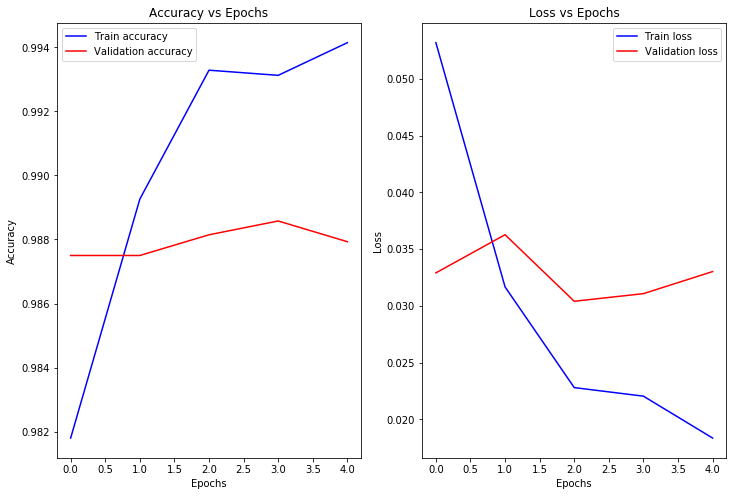

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Train accuracy', color = 'blue')
plt.plot(epochs_range, val_acc, label = 'Validation accuracy', color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Train loss', color = 'blue')
plt.plot(epochs_range, val_loss, label = 'Validation loss', color = 'red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

Using the MobileNet model, I achieved a validation accuracy of 98% in just 5 epochs.